In [ ]:
### To-Do
# 1) plot some variables before and after normalization. how do they compare?
# X) try batch normalization in the network? re-do step1 maybe?
# 3) to_categorical for signal and background preds?
# 4) grid optimization? --> dropout rate, layers, nodes, etc
# X) k-fold validation

In [4]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import normalize, to_categorical
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1, l2
from keras.models import load_model
from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

from lbn import LBN, LBNLayer

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

Using TensorFlow backend.


In [5]:
import sys, os
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

#model_dir = os.path.join(tut.data_dir, "lbn", "models", name)
#if not os.path.exists(model_dir):
#    os.makedirs(model_dir)


In [6]:
#*** 1. Import data and check stuff
testingFraction = 0.3

# *** A. Import Dataset
hh_raw, qcd_raw = importDatasets()

Dihiggs file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/pp2hh4b_500kEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv
QCD file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/ppTo4b_2MEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv


(array([3.3195e+04, 4.0870e+04, 2.5949e+04, 1.1225e+04, 3.8130e+03,
        1.1030e+03, 2.6100e+02, 5.6000e+01, 5.0000e+00, 4.0000e+00]),
 array([ 4. ,  4.9,  5.8,  6.7,  7.6,  8.5,  9.4, 10.3, 11.2, 12.1, 13. ]),
 <a list of 10 Patch objects>)

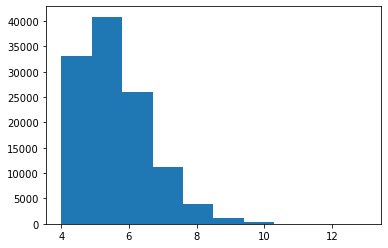

In [7]:
plt.hist(qcd_raw.nJets, bins=10)

In [8]:
# *** 2. Make mix of dihiggs and QCD for specified variables
jetLabels = ['1','2','3','4','5','6','7','8']
jetVariables = ['energy', 'px', 'py', 'pz']
variables_jetVects = ['jet{0}_{1}'.format(iJetLabel, iJetVariable) for iJetLabel in jetLabels for iJetVariable in jetVariables]

# *** 2. Split testing and training
jetVects_data_train, jetVects_data_test, jetVects_labels_train, jetVects_labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables_jetVects, testingFraction)

N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [9]:
# *** 2. Create jet vector inputs
def returnJetVectorInputsToLBN(_df, _jetType='jet', _nJets=4):
    
    #flattened
    _allVectorsFlattened = None
    _var = [_jetType+'{}_energy', _jetType+'{}_px', _jetType+'{}_py', _jetType+'{}_pz']
    
    for i in range(1, _nJets + 1):
        _varN = [x.format(i) for x in _var]
        _jetNData = _df[ _varN ].astype(np.float32)
        _vectN = [list(x) for x in _jetNData.values]
        
        if _allVectorsFlattened == None:
            _allVectorsFlattened = _vectN
        else:
            _allVectorsFlattened = [ x + y for x,y in zip(_allVectorsFlattened, _vectN) ]

    return np.array(_allVectorsFlattened)
    

nJets = 8
jetType = 'jet'
trainVectorsByEvent = returnJetVectorInputsToLBN( jetVects_data_train, jetType, nJets)
testVectorsByEvent  = returnJetVectorInputsToLBN( jetVects_data_test, jetType, nJets)

trainLabelsByEvent = np.array([[0.,1.] if x ==0 else [1.,0.] for x in jetVects_labels_train.isSignal]).astype(np.float32)
testLabelsByEvent  = np.array([[0.,1.] if x ==0 else [1.,0.] for x in jetVects_labels_test.isSignal]).astype(np.float32)

#np.array(jetVects_labels_train)
np.shape(trainVectorsByEvent)
#np.array(trainLabelsByEvent)

(136749, 32)

In [62]:
# *** 3A. Define LBN model and train
def createModelLBN(_nodesInFirstHiddenLayer=80, _nodesInSecondHiddenLayer=256, _hiddenActivation='relu', _outputActivation='sigmoid', _weightsFile=''):
    """make lbn model"""
    #init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=123)
 
    features = ["E", "pt", "eta", "phi", "m", "pair_dr"]
    lbn_layer = LBNLayer(n_particles=5, boost_mode="pairs", features=features)
    
    
    metrics = [
        tf.keras.metrics.categorical_accuracy,
        tf.keras.metrics.AUC(name='auc'),
    ]
    
    #l2_reg = l2(1e-4)
    
    l2_reg = tf.keras.regularizers.l2(1e-4)
    
    dense_kwargs_IML = dict(
        activation="selu",
        kernel_initializer=tf.keras.initializers.lecun_normal(),
        kernel_regularizer=l2_reg,
    )

    dense_kwargs = dict(
        activation=_hiddenActivation,
        kernel_initializer=tf.keras.initializers.lecun_normal(),
        kernel_regularizer=l2_reg,
    )

    _model = tf.keras.models.Sequential()

    #_model.add(LBNLayer(5, boost_mode=LBN.PAIRS, features=features))
    _model.add(lbn_layer)
    _model.add(tf.keras.layers.BatchNormalization(axis=1))


    _model.add(tf.keras.layers.Dense(80, **dense_kwargs))#, kernel_regularizer=l2_reg))
    _model.add(tf.keras.layers.Dense(256, **dense_kwargs))#, kernel_regularizer=l2_reg))


    #_model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=init))
    #_model.add(tf.keras.layers.Dense(750, activation='relu'))#, kernel_regularizer=l2_reg))
    #_model.add(tf.keras.layers.Dense(256, activation='relu'))
    #_model.add(tf.keras.layers.Dropout(0.2))
    #_model.add(BatchNormalization())

    #_model.add(tf.keras.layers.Dense(128, activation='relu'))
    #_model.add(tf.keras.layers.Dense(64, activation='relu'))
    #_model.add(tf.keras.layers.Dense(32, activation='relu'))

    _model.add(tf.keras.layers.Dense(2, activation=_outputActivation, kernel_regularizer=l2_reg))
        
    _model.compile(loss='binary_crossentropy',
                  #loss='mean_squared_error',
                  optimizer='adam',
                  #metrics=['accuracy']
                  metrics = metrics
                 )

    #print(_model.weights)
    
    if _weightsFile !='':
        _model = _model.get_weights(_weightsFile)
        for _layer in _model.layers:
            _layer.trainable_ = False

    return _model

In [73]:
def fit_model(model, name, data=None, validation_data=None, epochs=10, batch_size=512):
    topDir = '/home/btannenw/Desktop/ML/dihiggsMLProject/lorentzBoostNetwork/'
    
    model_dir = os.path.join(topDir, "lbn", "models", name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    fit_callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(model_dir, name),
            save_best_only=True,
            save_weights_only=True,
            monitor="val_auc",
            mode="max",
        ),
    ]

    if data is None:
        data = (trainVectorsByEvent, trainLabelsByEvent)
    if validation_data is None:
        validation_data = (testVectorsByEvent, testLabelsByEvent)

    model.fit(data[0], data[1],
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=fit_callbacks,
    )

    return model


def load_model(model, name):
    topDir = '/home/btannenw/Desktop/ML/dihiggsMLProject/lorentzBoostNetwork/'

    local_dir = os.path.join(topDir, "lbn", "models", name)
    print("loading model from {}".format(local_dir))
    model.load_weights(os.path.join(local_dir, name))

    return model

In [74]:
model_t = createModelLBN(_outputActivation='sigmoid') # 1.81+/0.06

fit_model(model_t, name='model_t', data=(trainVectorsByEvent, trainLabelsByEvent), 
          validation_data=(testVectorsByEvent, testLabelsByEvent), epochs=4, batch_size=400)

Train on 136749 samples, validate on 58608 samples
Epoch 1/4
136749/136749 [==============================] - 7s 50us/sample - loss: 0.6050 - categorical_accuracy: 0.6917 - auc: 0.7656 - val_loss: 0.5703 - val_categorical_accuracy: 0.7151 - val_auc: 0.7975
Epoch 2/4
136749/136749 [==============================] - 4s 30us/sample - loss: 0.5479 - categorical_accuracy: 0.7340 - auc: 0.8162 - val_loss: 0.5331 - val_categorical_accuracy: 0.7444 - val_auc: 0.8269
Epoch 3/4
136749/136749 [==============================] - 4s 32us/sample - loss: 0.5256 - categorical_accuracy: 0.7486 - auc: 0.8317 - val_loss: 0.5177 - val_categorical_accuracy: 0.7550 - val_auc: 0.8369
Epoch 4/4
136749/136749 [==============================] - 4s 31us/sample - loss: 0.5120 - categorical_accuracy: 0.7579 - auc: 0.8407 - val_loss: 0.5092 - val_categorical_accuracy: 0.7595 - val_auc: 0.8424


In [75]:
model_t.predict(testVectorsByEvent[5:10])
model_t.weights
#pred_qcd = model.predict(np.array(qcd_data_test))

model_u = createModelLBN(_outputActivation='sigmoid') # 1.81+/0.06

load_model(model_u, "model_t.hdf5")

loading model from /home/btannenw/Desktop/ML/dihiggsMLProject/lorentzBoostNetwork/lbn/models/model_t.hdf5


ValueError: Weights for model sequential_67 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [13]:
#es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=.001)

#mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', mode='min', save_best_only=True)
mc = ModelCheckpoint('best_model.hdf5', #filepath=os.path.join(model_dir, name),
                    monitor="val_loss", mode='min', save_weights_only=True, save_best_only=True)
 

#model = createModelLBN(_outputActivation='softmax') # 1.77+/0.04, 1.84 +/- 0.06
model = createModelLBN(_outputActivation='sigmoid') # 1.81+/0.06

history = model.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=5, validation_data = (testVectorsByEvent, testLabelsByEvent), batch_size=400, callbacks=[es, mc])
#history = model.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=10, validation_data = (testVectorsByEvent, testLabelsByEvent))
print(model.count_params())

# load the saved model
#model_best = model.load_weights('best_model.h5')

Train on 136749 samples, validate on 58608 samples
Epoch 1/5
136749/136749 [==============================] - 10s 75us/sample - loss: 0.5828 - categorical_accuracy: 0.6965 - auc: 0.7752 - val_loss: 0.5461 - val_categorical_accuracy: 0.7271 - val_auc: 0.8094
Epoch 2/5
136749/136749 [==============================] - 7s 48us/sample - loss: 0.5288 - categorical_accuracy: 0.7414 - auc: 0.8239 - val_loss: 0.5136 - val_categorical_accuracy: 0.7522 - val_auc: 0.8352
Epoch 3/5
136749/136749 [==============================] - 7s 52us/sample - loss: 0.5022 - categorical_accuracy: 0.7607 - auc: 0.8436 - val_loss: 0.4919 - val_categorical_accuracy: 0.7664 - val_auc: 0.8507
Epoch 4/5
136749/136749 [==============================] - 7s 50us/sample - loss: 0.4856 - categorical_accuracy: 0.7731 - auc: 0.8553 - val_loss: 0.4779 - val_categorical_accuracy: 0.7748 - val_auc: 0.8600
Epoch 5/5
136749/136749 [==============================] - 8s 58us/sample - loss: 0.4729 - categorical_accuracy: 0.7814 - au

In [2]:
# *** 3B. Define low-level NN using jet vectors for comparison
model_nn = tf.keras.models.Sequential()
nInputNodes = len(trainVectorsByEvent[0]) 
#model.add(Dense(100, input_dim=nInputNodes, activation='relu'))

model_nn.add(tf.keras.layers.Dense(128, input_dim = nInputNodes, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(BatchNormalization())

model_nn.add(tf.keras.layers.Dense(64, activation='relu'))
model_nn.add(tf.keras.layers.Dense(32, activation='relu'))
model_nn.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model_nn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_nn = model_nn.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=50, validation_data = (testVectorsByEvent, testLabelsByEvent), batch_size=400)
#history = model.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=10, validation_data = (testVectorsByEvent, testLabelsByEvent))
print(model_nn.count_params())

NameError: name 'tf' is not defined

In [51]:
#model = model_best
blank_model = createModelLBN()
best_model = createModelLBN('best_model.hdf5')

model.save_weights('dummy.hdf5', overwrite=True)
dumb_model = createModelLBN('dummy.hdf5')

#model_best = load_weights('/home/btannenw/Desktop/ML/dihiggsMLProject/lorentzBoostNetork/best_model.h5')
print(type(model), type(best_model), type(blank_model))
#best_model = model.load_weights('best_model.hdf5')
#best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(type(model), type(best_model), type(dumb_model))



dumb_model.predict(testVectorsByEvent[0:10])
print(dumb_model.weights)

#dumb_model.predict(testVectorsByEvent[5:10])
#print(dumb_model.weights)

#dumb_model.save_weights('dummy2.hdf5')
#print(np.shape(trainVectorsByEvent), np.shape(testVectorsByEvent))
print(model.input_shape)

ValueError: Weights for model sequential_57 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [44]:
# *** 4. Do some very specific evaluation based on pure samples
hh_data_test, hh_labels_test, qcd_data_test, qcd_labels_test = returnTestSamplesSplitIntoSignalAndBackground(testVectorsByEvent, testLabelsByEvent)

#score_hh = model.evaluate(np.array(hh_data_test), np.array(hh_labels_test))
#score_qcd = model.evaluate(np.array(qcd_data_test), np.array(qcd_labels_test))
#print(score_hh, score_qcd)

#pred_hh = best_model.predict(np.array(hh_data_test))
#pred_qcd = best_model.predict(np.array(qcd_data_test))

pred_hh = model.predict(np.array(hh_data_test))
pred_qcd = model.predict(np.array(qcd_data_test))

(58608, 2)


In [ ]:
print(model.weights)

In [ ]:
_nBins = 40
predictionResults = {'hh_pred':pred_hh[:,0], 'qcd_pred':pred_qcd[:,0]}
compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'LBN Signal Score', 0, 1, _nBins, _yMax = 5, _normed=True, _savePlot=False )


In [ ]:
# *** 4. Get best cut value for ff-NN assuming some minimal amount of signal
returnBestCutValue('ff-NN', pred_hh[:,0].copy(), pred_qcd[:,0].copy(), _minBackground=200, _testingFraction=testingFraction)

In [ ]:
# *** 5. Get signifiance for any user-specified NN score cut value
lumiscale_hh  = getLumiScaleFactor(testingFraction, True)
lumiscale_qcd = getLumiScaleFactor(testingFraction, False)
cut = 0.81
_nSignal = sum( value > cut for value in pred_hh)*lumiscale_hh
_nBackground = sum( value > cut for value in pred_qcd)*lumiscale_qcd

print('nSig = {0} , nBkg = {1} with significance = {2} for NN score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), cut) )

In [ ]:
import pickle
pickle.dump(model, open('models/allVars_100-50-50.pkl', 'wb'))


In [ ]:
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('LBN Accuracy')
plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LBN Model Loss')
plt.ylabel('Loss [A.U.]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('LBN Model AUC')
plt.ylabel('AUC [A.U.]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
model.summary()

In [ ]:
# ROC curve and AUC
testVectorsByEvent_ROC = testVectorsByEvent.copy()
#top10_data_test_ROC = top10_data_test__norm.copy()
#top10_data_test_ROC = top10_data_test_ROC.drop('isSignal', axis=1)

y_pred = model.predict(testVectorsByEvent_ROC).ravel()
falsePositiveRate, truePositiveRate, thresholds = roc_curve(testLabelsByEvent, y_pred)
auc_keras = auc(falsePositiveRate, truePositiveRate)

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(falsePositiveRate, truePositiveRate, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
var = ['jet{}_E', 'jet{}_px', 'jet{}_py', 'jet{}_pz', 'jet{}_m']
for i in range(1,5):
    varN = [x.format(i) for x in var]
    print(varN)

In [ ]:
je

In [21]:
model.layers[0].trainable

True

In [37]:
dumb_model = createModelLBN('dummy.hdf5')
dumb_model.layers[0] = False
dumb_model.layers[1].trainable

True